In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import astropy.units as u
from sunpy.time import TimeRange
import time
import sys
import os

import datetime as dt
import matplotlib.dates as mdates
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib import gridspec,transforms

mpl.use('nbagg')
%matplotlib inline

In [2]:
sys.path.insert(1, '../../20201013_jupiter/')
from sk import LofarRaw
import ed_flagger as edf
import ilofar_ueds_rfi as ued
import waterfall as wf

In [3]:
filename = '../udpoutput/uranus-stokesVectors_0_2020-12-15T20:04:00_19629670898060' #0 is I and 1 is V I assume
sV = '../udpoutput/uranus-stokesVectors_1_2020-12-15T20:04:00_19629670898060'
off_fname = '../udpoutput/offsource-stokesVectors_0_2020-12-15T20:04:00_19629670898060'
frange = [15,30]
sbs = np.arange(76,198)
obs_mode = 3
time_len_mins = 176.
trange = TimeRange(filename.split('_')[-2], time_len_mins*u.min)
xlabel = "Time on {} (UTC)".format(filename.split('_')[-2].split('T')[0])
ylabel = "Frequency (MHz)"
title = filename.split('/')[2]
no_sbs = 78
nsplit = 10

In [4]:
#on-beam
rawdata = LofarRaw(fname=filename, sbs=sbs, obs_mode=obs_mode, frange=frange)
rawdata.data = rawdata.data[:,:no_sbs] #need to do this because of the way subbands were set up for uranus observations! (only use 78 subbands!)
#off-beam
rawoffdata = LofarRaw(fname=off_fname, sbs=sbs, obs_mode=obs_mode, frange=frange)
rawoffdata.data = rawoffdata.data[:,:no_sbs]
#stokes V
sV_data = LofarRaw(fname=sV, sbs=sbs, obs_mode=obs_mode, frange=frange)
sV_data.data = sV_data.data[:,:no_sbs]



Time to read data: 0.000644s

Time to read data: 0.000260s

Time to read data: 0.000251s



In [9]:
freqs_sbs = rawdata.sb_to_f(sbs[:78], 3)

In [10]:
freqs_sbs[1] - freqs_sbs[0]

<Quantity 0.1953125 MHz>

In [5]:
df_chunk = ued.data_chunker(rawdata.data, nsplit)
off_chunk = ued.data_chunker(rawoffdata.data, nsplit)
sV_chunks = ued.data_chunker(sV_data.data, nsplit)
tchunks = trange.split(nsplit)

In [54]:
strings = ["StokesI", "StokesI_OFF", "StokesV"]
#strings = ["StokesV"]
for i,df in enumerate([df_chunk, off_chunk, sV_chunks]):
    #for i,df in enumerate([sV_chunks]):
    total_f_sum = []
    print("Analysing {}".format(strings[i]))
    for n,df_split in enumerate(df):
        print("Analysing Chunk #{}".format(n+1))
        ylims, xlims = ued.get_data_lims(sbs, obs_mode, no_sbs, tchunks[n])
        print("Removing RFI")
        df_norfi = ued.resample_dataset(df_split, f=1220) #resampled to 100 ms resolution to mask rfi shorter than this
        rfi_mask = edf.basic_filter(df_norfi, 4.)
        rfi_begone = np.ma.MaskedArray(df_norfi, rfi_mask)
        df_rs = ued.resample_dataset(rfi_begone, f=4) #this is the 2nd resample so be wary of numbers here. 
        df_filtered = edf.basic_filter(df_rs.T, 4.) #4 sigma
        ued.plot_data(df_filtered, None, None, xlims, ylims, xlabel, ylabel, "ed_flags/{}".format(strings[i])+str(n+1), "Electrostatic Filtering {}".format(strings[i]), gs=True)
        f_sum = edf.get_hist_dynspec(df_filtered, axis=0)
        total_f_sum.append(f_sum)
        #t_sum = edf.get_hist_dynspec(df_filtered, axis=0)
    plt.close()
    f = plt.figure()
    f.set_facecolor('white')
    plt.bar(np.arange(f_sum.shape[0]), np.sum(total_f_sum, axis=0))
    plt.savefig("ed_flags/histogram_frequency_{}".format(strings[i]))
    os.rename('trigger_indices.dat', 'trigger_indices_{}.dat'.format(strings[i]))

Analysing StokesI
Analysing Chunk #1
Removing RFI
	Data downsampled x1220
	Data shape: (10567, 78)
	Data downsampled x4
	Data shape: (2642, 78)

Plotting...

Not using summed axes!
Analysing Chunk #2
Removing RFI
	Data downsampled x1220
	Data shape: (10567, 78)
	Data downsampled x4
	Data shape: (2642, 78)

Plotting...

Not using summed axes!
Analysing Chunk #3
Removing RFI
	Data downsampled x1220
	Data shape: (10567, 78)
	Data downsampled x4
	Data shape: (2642, 78)

Plotting...

Not using summed axes!
Analysing Chunk #4
Removing RFI
	Data downsampled x1220
	Data shape: (10567, 78)
	Data downsampled x4
	Data shape: (2642, 78)

Plotting...

Not using summed axes!
Analysing Chunk #5
Removing RFI
	Data downsampled x1220
	Data shape: (10567, 78)
	Data downsampled x4
	Data shape: (2642, 78)

Plotting...

Not using summed axes!
Analysing Chunk #6
Removing RFI
	Data downsampled x1220
	Data shape: (10567, 78)
	Data downsampled x4
	Data shape: (2642, 78)

Plotting...

Not using summed axes!
Anal

In [11]:
dft, newt, ylims, xlims = wf.zoom_window(rawdata, df_chunk[1], tchunks[1], 8, 0, no_sbs)
dft, newt, ylims, xlims = wf.zoom_window(rawdata, dft, newt, 8, 4, no_sbs)
dft, newt, ylims, xlims = wf.zoom_window(rawdata, dft, newt, 8, 7, no_sbs)
dft, newt, ylims, xlims = wf.zoom_window(rawdata, dft, newt, 3, 0, no_sbs)
dft, newt, ylims, xlims = wf.zoom_window(rawdata, dft, newt, 4, 2, no_sbs)
ued.plot_data(dft, np.nansum(dft.T, axis=0), np.nansum(dft.T, axis=1), xlims, ylims, xlabel, ylabel, "ed_flags/event_202210UTC/zoom5", "ED event zoom", gs=True)
xlims2 = np.linspace(xlims[0], xlims[1], dft.shape[0])
xlims2 = np.array([xlims2[1400], xlims2[1600]])
wf.plot_event_1d(dft, xlims, sbs, obs_mode, interval=1000)
plt.savefig('ed_flags/event_202210UTC/1dplot')
plt.close()
wf.waterfall_plot(dft, xlims, sbs, obs_mode, sbs_interval=7, interval=50000)
plt.savefig('ed_flags/event_202210UTC/wfplot')


Plotting...



In [20]:
dft, newt, ylims, xlims = wf.zoom_window(rawdata, sV_chunks[1], tchunks[1], 8, 0, no_sbs)
dft, newt, ylims, xlims = wf.zoom_window(rawdata, dft, newt, 8, 4, no_sbs)
dft, newt, ylims, xlims = wf.zoom_window(rawdata, dft, newt, 8, 7, no_sbs)
dft, newt, ylims, xlims = wf.zoom_window(rawdata, dft, newt, 3, 0, no_sbs)
dft, newt, ylims, xlims = wf.zoom_window(rawdata, dft, newt, 4, 2, no_sbs)
ued.plot_data(dft, np.nansum(dft.T, axis=0), np.nansum(dft.T, axis=1), xlims, ylims, xlabel, ylabel, "ed_flags/event_202210UTC/zoom5_stokesV", "ED event zoom", gs=True)
xlims2 = np.linspace(xlims[0], xlims[1], dft.shape[0])
xlims2 = np.array([xlims2[1400], xlims2[1600]])
wf.plot_event_1d(dft, xlims, sbs, obs_mode, interval=1000)
plt.savefig('ed_flags/event_202210UTC/1dplot_StokesV')
plt.close()
wf.waterfall_plot(dft, xlims, sbs, obs_mode, sbs_interval=7, interval=50000)
plt.savefig('ed_flags/event_202210UTC/wfplot_StokesV')


Plotting...



In [15]:
xlims2 = np.linspace(xlims[0], xlims[1], dft.shape[0])
xlims2 = np.array([xlims2[500], xlims2[1000]])
wf.waterfall_plot(dft[500:1000], xlims2, sbs, obs_mode, sbs_interval=7, interval=10000)
plt.savefig('ed_flags/event_202210UTC/wfplot')

In [17]:
ys = np.nansum(dft, axis=0)
print(ys.shape)
ys_x = np.linspace(0, ys.shape[0], ys.shape[0])
smooth_fit = np.poly1d(np.polyfit(ys_x, ys, 2))
smooth_fresponse = smooth_fit(ys_x)
dft_n = dft / smooth_fresponse

#dft_n = dft / np.mean(dft, axis=1)

(78,)


In [19]:
ued.plot_data(dft_n, np.nansum(dft_n.T, axis=0), np.nansum(dft_n.T, axis=1), xlims, ylims, xlabel, ylabel, "ed_flags/event_202210UTC/zoom5_fnorm", "ED event zoom", gs=True)


Plotting...



In [12]:
dft.shape

(2098, 78)

In [12]:
%matplotlib inline

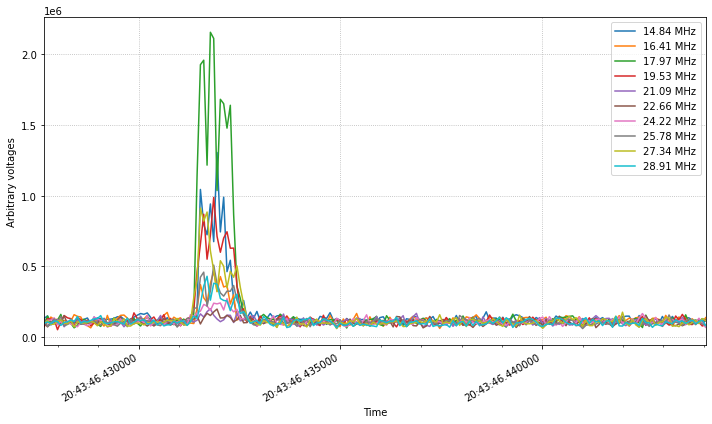

In [13]:
xlims2 = np.linspace(xlims[0], xlims[1], dft.shape[0])
xlims2 = np.array([xlims2[1400], xlims2[1600]])
wf.plot_event_1d(dft[1400:1600], xlims2, sbs, obs_mode, sbs_interval=8, interval=1000)
plt.savefig('ed_flags/event_204346.43UTC/1dplot')

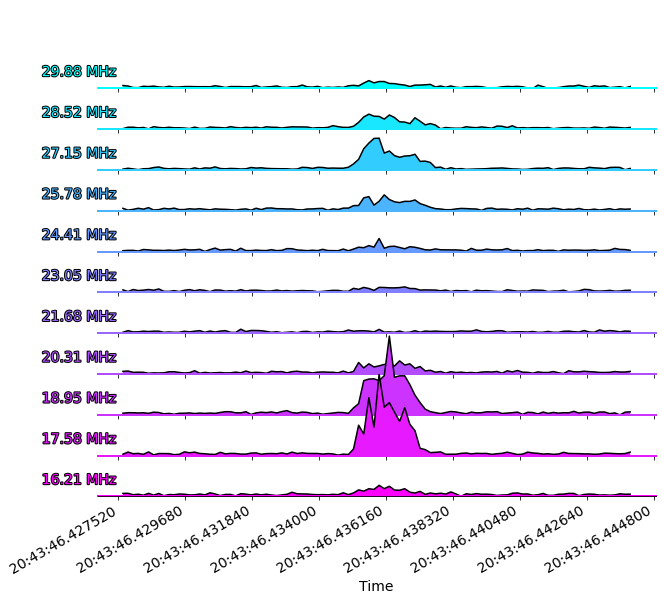

In [14]:
wf.waterfall_plot(dft[1400:1500], xlims2, sbs, obs_mode, sbs_interval=7, interval=50000)
plt.savefig('ed_flags/event_204346.43UTC/waterfall')

In [47]:
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
ued = pd.DataFrame(ued)
g = sns.FacetGrid(ued, row="g", hue="g", aspect=15, height=.5, palette=pal)

In [49]:
u2 = np.ndarray.flatten(ued)